In [1]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from compositional_metarl.task import MultiArmedBandit, BlockMABs
from compositional_metarl.model import QDNDLSTM as Agent
from compositional_metarl.utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference, one_hot_embedding
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import BlockTrainer as Trainer
from compositional_metarl.trainers import evaluate

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [2]:
'''init task'''

start_arm = 0
end_arm = 7
n_arms = (end_arm - start_arm) + 1
n_rounds_per_kernel = 1 # per function
n_blocks = 150
n_trials = 10
composition_block = False
normalize_rewards = True
noise_per_arm = None #'per_arm'
cue_per_epoch = True
CUES =  {'linperiodic': [1., 1.]}
ctx_dim = len(CUES['linperiodic'])
n_cues = len(CUES)
aoi = {'linear': 7, 'periodic': 1,
       'linperiodic': 6}   

In [3]:
bandit = MultiArmedBandit(start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds_per_kernel, 
                        normalize=normalize_rewards, noise_per_arm=noise_per_arm, cue_per_epoch=cue_per_epoch,
                        best_arms=aoi)
task = BlockMABs(bandit, cues=CUES, num_blocks=n_blocks, composition_block=composition_block, num_rounds=n_rounds_per_kernel)

In [4]:
'''init model'''

# DNDLSTM params
dim_hidden = 48 #64
inp_dim = None
inputs = 'context_block_action_reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'cosine' # 'l1' or 'l2'
dnd_policy = 'softmax' # 'softmax' or '1NN'
unique_keys = True
exclude_key = True

In [5]:
agent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, ctx_dim=ctx_dim, inputs=inputs, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)

In [6]:
'''init trainer'''

n_epochs = 1000
learning_rate = 1e-3 #5e-4 
gamma = 0.8 # 0.8
simulate_annealing = False
beta = .05 # weight for entropy loss
normalize_return = True
early_stopping = False
infer_composition = False

In [7]:
trainer = Trainer(agent, task, early_stopping=early_stopping, seed=seed_val, lr=learning_rate, n_trials=n_trials, beta=beta, 
                  gamma=gamma, normalize_return=normalize_return, simulate_annealing=simulate_annealing, infer_composition=infer_composition, n_epochs=n_epochs)

In [ ]:
'''train model'''
out, avg_train_loss, avg_cum_rewards, _ = trainer.train()
n_epochs = trainer.current_epoch 

Epoch 1 / 1000| cum. return = 0.49 | loss: val = 0.24, pol = 0.20, entropy = 2.01 | time = 6.99
Epoch 2 / 1000| cum. return = 0.51 | loss: val = 0.13, pol = 0.02, entropy = 2.03 | time = 6.79
Epoch 3 / 1000| cum. return = 0.50 | loss: val = 0.12, pol = 0.04, entropy = 2.01 | time = 7.00
Epoch 4 / 1000| cum. return = 0.51 | loss: val = 0.10, pol = 0.00, entropy = 2.05 | time = 6.88
Epoch 5 / 1000| cum. return = 0.52 | loss: val = 0.09, pol = -0.01, entropy = 2.03 | time = 6.48
Epoch 6 / 1000| cum. return = 0.50 | loss: val = 0.11, pol = 0.03, entropy = 2.05 | time = 6.39
Epoch 7 / 1000| cum. return = 0.50 | loss: val = 0.11, pol = -0.02, entropy = 2.07 | time = 6.30
Epoch 8 / 1000| cum. return = 0.51 | loss: val = 0.10, pol = -0.00, entropy = 2.04 | time = 6.19
Epoch 9 / 1000| cum. return = 0.50 | loss: val = 0.11, pol = 0.00, entropy = 2.04 | time = 6.32
Epoch 10 / 1000| cum. return = 0.49 | loss: val = 0.09, pol = -0.02, entropy = 2.06 | time = 6.62
Epoch 11 / 1000| cum. return = 0.50

## save model

In [47]:
train_protocol = 'ControlScheme'
filename = f"agent_{train_protocol}_{inputs}_hiddim{dim_hidden}_kernel{kernel}_policy{dnd_policy}"

## figures

In [19]:
n_epochs = trainer.current_epoch

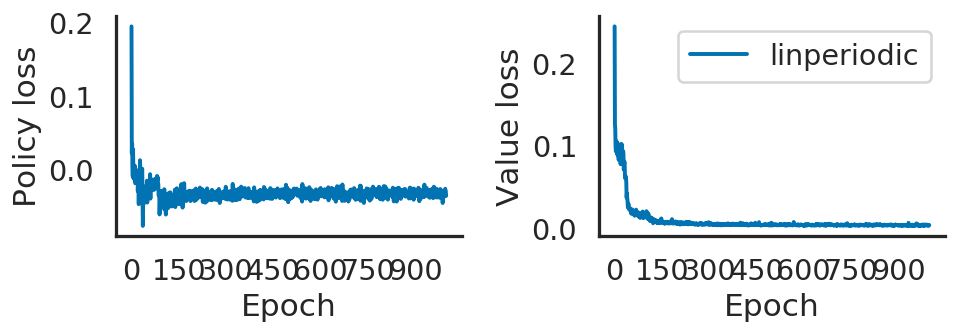

In [20]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(trainer.log_loss_policy.mean(1)[:n_epochs])
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(trainer.log_loss_value.mean(1)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(CUES)
sns.despine()
f.tight_layout()

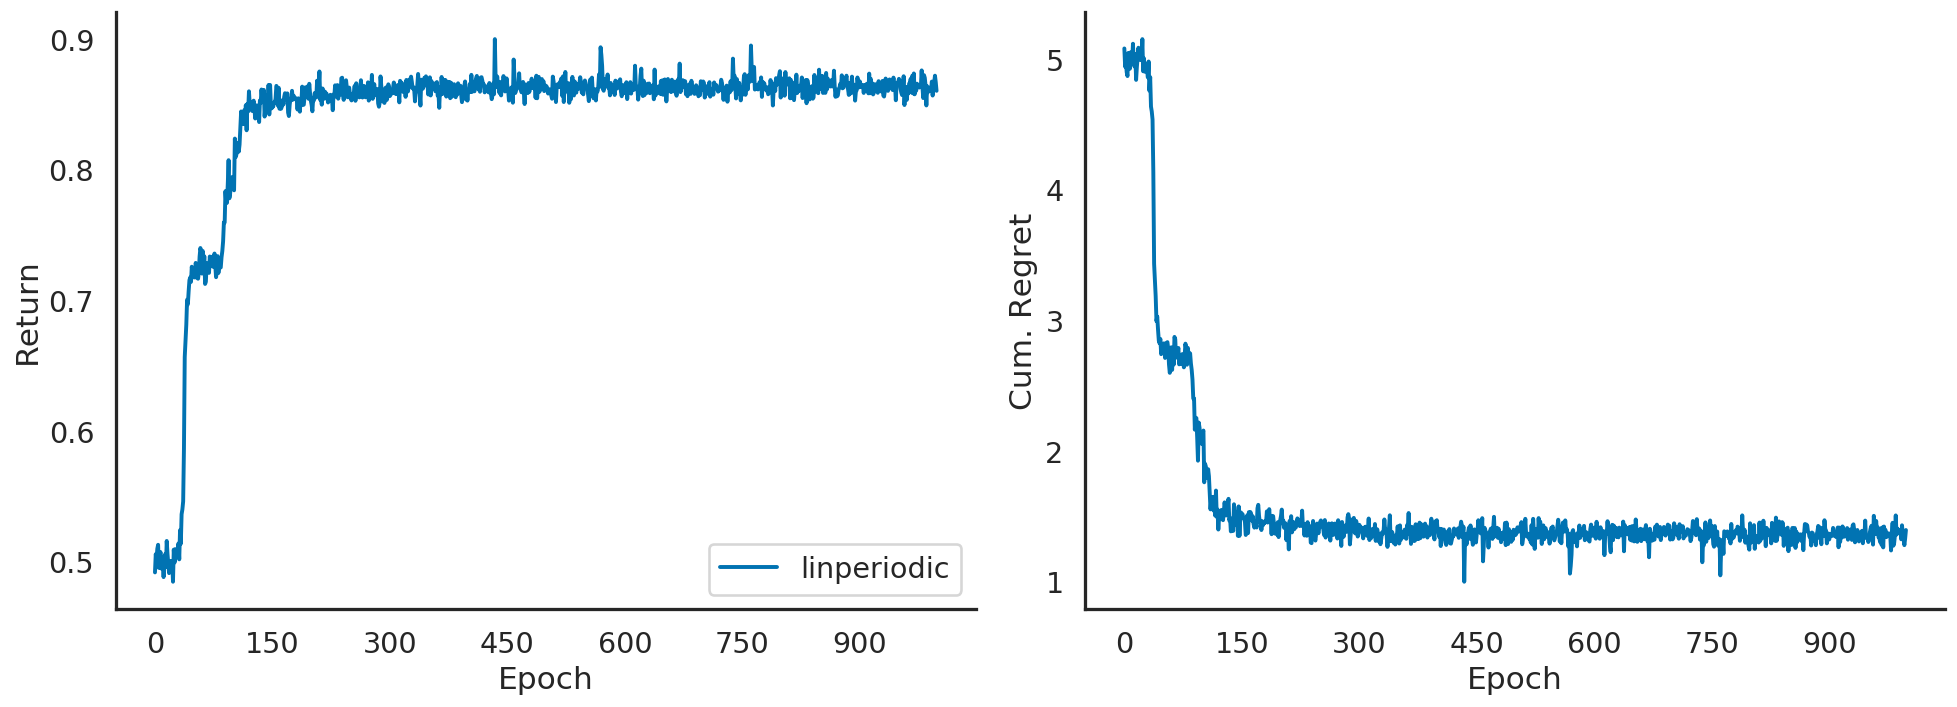

In [21]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=125)
axes[0].plot(trainer.log_cum_return.mean(2)[:n_epochs, 0])
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].plot(np.repeat(log_Y[:, 0, :, 7].mean(1).mean(), n_epochs), '_k')

# axes[1].plot(log_regret.mean(3).mean(2)) # mean regreat across trials and rounds
axes[1].plot(trainer.log_regret.cumsum(3).max(3).mean(2)[:n_epochs, 0])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(CUES)
sns.despine()
f.tight_layout()

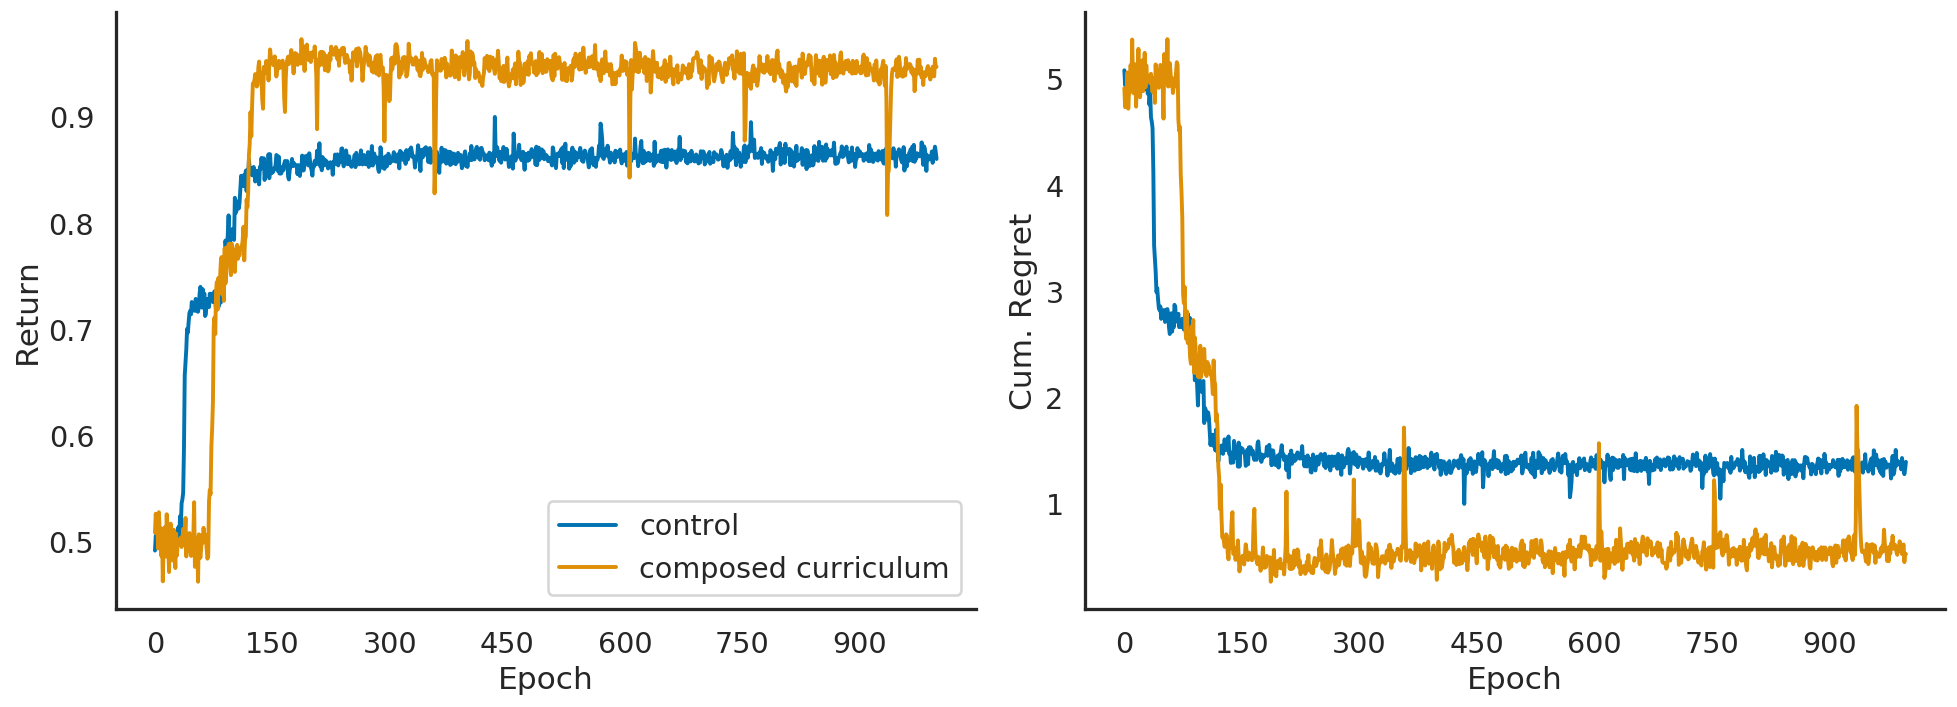

In [22]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=125)
axes[0].plot(trainer.log_cum_return.mean(2)[:n_epochs, 0])
axes[0].plot(data['log_cum_return'].mean(2)[:n_epochs, 2])
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].plot(np.repeat(log_Y[:, 0, :, 7].mean(1).mean(), n_epochs), '_k')

# axes[1].plot(log_regret.mean(3).mean(2)) # mean regreat across trials and rounds
axes[1].plot(trainer.log_regret.cumsum(3).max(3).mean(2)[:n_epochs, 0])
axes[1].plot(data['log_regret'].cumsum(3).max(3).mean(2)[:n_epochs, 2])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(['control', 'composed curriculum'])
sns.despine()
f.tight_layout()

## load model

In [38]:
''' model evaluation for different cues'''

block = ['linpos', 'perodd', 'linperiodic'] 
if composition_block is False:
    trainer.dataloaders.evaluate_control()
X, Y, S = trainer.dataloaders.sample(end_rnd=1, block=block)
n_runs = 1000

# create block structure
X, Y, S, _ = trainer.dataloaders.prepare_data(X, Y, S, block, n_trials)
total_trials =  n_trials if trainer.dataloaders.eval_control else len(block) * n_trials
init_at = None

In [39]:
actions, rewards, values, regrets =  np.zeros((n_runs, total_trials)),  np.zeros((n_runs, total_trials)), np.zeros((n_runs, total_trials, n_arms)),  np.zeros((n_runs, total_trials))

for run_id in range(n_runs):
    actions[run_id], rewards[run_id], regrets[run_id], values[run_id] = run_model_eval(agent, X, Y, S)

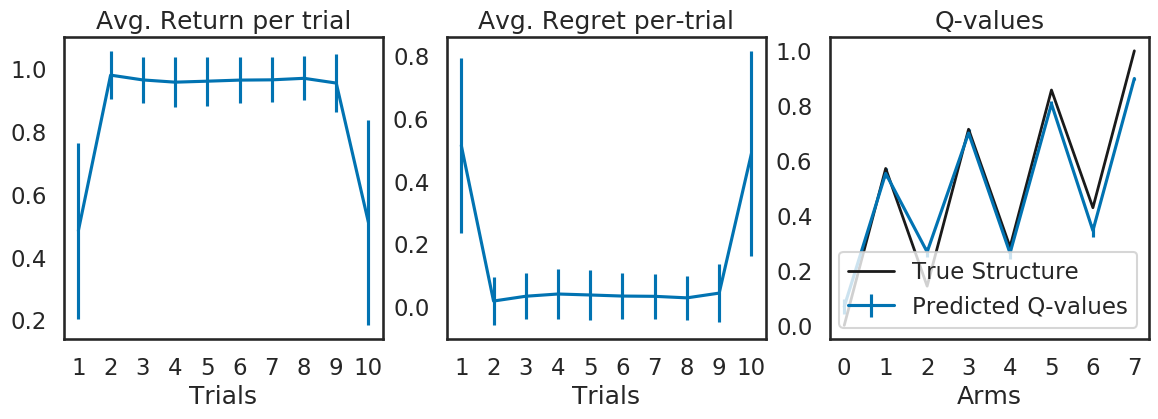

In [40]:
# avg reward across trials
f, ax = plt.subplots(1, 3, figsize=(14, 4), dpi=100)
ax[0].errorbar(range(1, n_trials+1), rewards.mean(0), yerr=rewards.std(0))
ax[0].set_title('Avg. Return per trial')
ax[0].set_xlabel('Trials')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# avg regret across trials
ax[1].errorbar(range(1, n_trials+1), regrets.mean(0), yerr=regrets.std(0))
ax[1].set_title('Avg. Regret per-trial')
ax[1].set_xlabel('Trials')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
 
# avg qvalues
ax[2].plot(Y[0].T, 'k', lw=2, label='True Structure')
ax[2].errorbar(range(n_arms), values.mean(0).mean(0), yerr=values.mean(1).std(0), label='Predicted Q-values')
ax[2].set_title('Q-values')
ax[2].set_xlabel('Arms')
ax[2].legend(loc='lower right')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [27]:
def run_model_eval(agent, X, Y, S, init_at=None):
    
    aa, vv, rr, rs =  [], [], [], []
    
    # run model for n_runs
    agent.eval()
    agent.turn_off_encoding()

    # set init states
    h_t, c_t = agent.get_init_states()
    h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
    r_t = Y[0].mean() 
    a_t = init_at
    
    # run model
    for t in range(total_trials):
        x_t = X[t] 
        s_t = S[t]
        trial = t%n_trials
        
        if agent.inputs == 'context_block_action_reward':
            one_hot_a_t = one_hot_embedding(a_t, n_arms)
            x_t = torch.cat((x_t.type(torch.FloatTensor), s_t.reshape(-1).type(torch.FloatTensor), one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                             r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(trial).reshape(-1).type(torch.FloatTensor)), dim=0)
        output_t, c = agent(x_t, h_t, c_t)
        a_t, prob_a_t, v_t, h_t, c_t = output_t
        f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c

        # bootstrap reward from q-values
        r_t = Y[t][a_t] 

        # predicted q-value
        Q = q_t.detach().numpy().T
        Q = Q - Q.min()
        Q = Q/Q.max()

        # store results
        rs.append(r_t)
        aa.append(a_t) 
        rr.append(Y[t].max() - r_t)
        vv.append(Q)
    
    return torch.stack(aa), torch.stack(rs), torch.stack(rr), np.hstack(vv).T

In [28]:

def one_hot_embedding(arm, num_arms):
    """Embedding labels to one-hot form.

    Args:
      arms: (LongTensor) arms for which embedding is required, sized [N,].
      num_arms: (int) number of arms.

    Returns:
      (tensor) encoded arms, sized [N, #classes].
    """
    y = torch.eye(num_arms) 
    
    return torch.zeros(num_arms) if arm is None else y[arm]
    